<h1 style="text-align: center;>Image Caption Generator</h1>

<h1 style="text-align: center;""> Image Caption Generator</h1>

In [1]:
# importing libraries
import os
import numpy as np
import pandas as pd
import warnings
import tensorflow as tf
from tensorflow import keras
print("Tensorflow Version: ",tf.__version__)

2025-09-30 01:22:08.945502: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759195328.971785   97496 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759195328.979768   97496 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow Version:  2.18.0


In [2]:
IMAGE_DIR = "/kaggle/input/flickr8k/Images"
captions_df = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
captions_df.sample(5)

,image,caption
6800,2264316030_600e55748d.jpg,A brown and black dog walks in the snow with i...
33419,3643087589_627a0a9e01.jpg,Two dogs playing in a yard .
26521,3367851138_757d6bd2ef.jpg,A man standing on the dock beside a building a...
26848,3382105769_b1a4e4c60d.jpg,A dog with a stick in its mouth runs through t...
37532,495116214_f1df479fb0.jpg,Two dogs holding one stick on a beach .


### Visualizing images

In [3]:
# importing libraries for visulization
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

In [4]:
def show_images_with_captions(full_df,df_sample):
    unique_images = df_sample['image'].unique()

    # rows needed (4 per row)
    n_rows = (len(unique_images) + 3) // 4
    fig, axes = plt.subplots(n_rows, 4, figsize=(20, 5 * n_rows))
    axes = axes.flatten()
    
    for idx, filename in enumerate(unique_images):
        ax = axes[idx]
        # get all captions for this image from full dataframe
        all_captions = full_df[full_df['image'] == filename]['caption'].tolist()

        # image loading
        img = load_img(f"{IMAGE_DIR}/{filename}", color_mode='rgb')
        ax.imshow(img)
        ax.axis("off")

        # Add all captions below image
        captions_text = "\n".join([f"{i+1}. {cap}" for i, cap in enumerate(all_captions)])
        ax.text(
            0.5, -0.15, captions_text,
            transform=ax.transAxes,
            ha="center", va="top", fontsize=9, wrap=True
        )

    # hide extra axes
    for j in range(idx+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

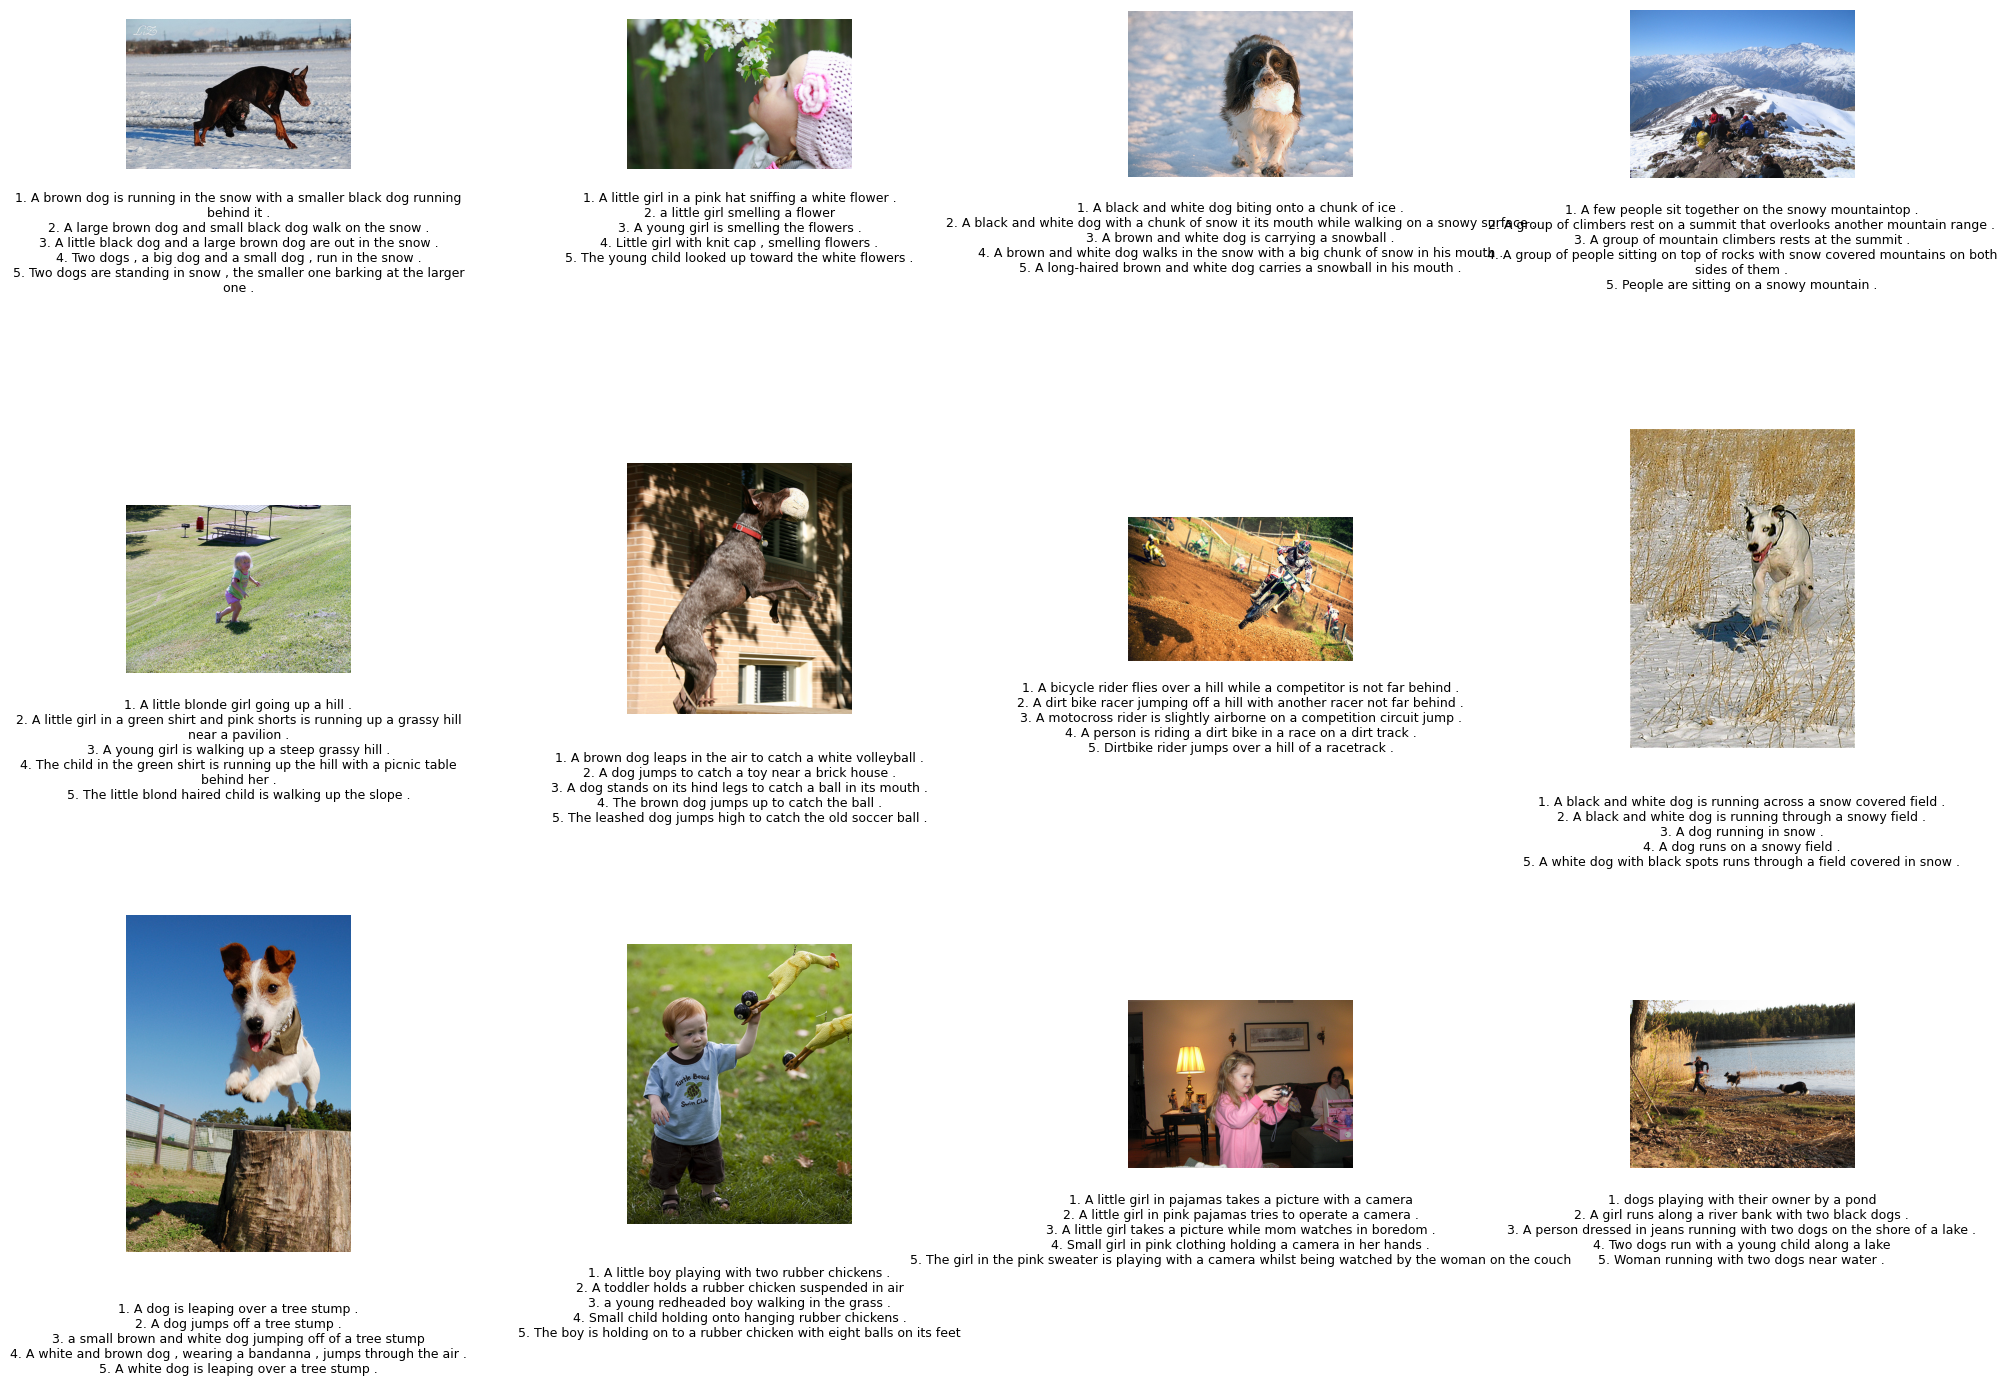

In [5]:
show_images_with_captions(captions_df, captions_df.sample(12))

## Extracting image features:

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm

In [7]:
# loading VGG16 model
model = VGG16()
# removing last layer of model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

I0000 00:00:1759195338.776103   97496 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
features = {}

# Loop through each unique image
for image in tqdm(captions_df['image'].unique().tolist()):
    img = load_img(os.path.join(IMAGE_DIR,image), target_size=(224,224))
    # convert image pixels to numpy array
    img = img_to_array(img)
    # preprocessing image for VGG
    img = preprocess_input(img)
    # model.predict expects a batch, i.e. (batch_size, 224, 224, 3).
    img = np.expand_dims(img, axis=0)  # makes shape (1,224,224,3)
    # feature extracting
    feature = model.predict(img,verbose=0)
    # image id 
    image_id = image.split('.')[0]
    # storing feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1759195342.682370   97550 service.cc:148] XLA service 0x7db524004ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759195342.682418   97550 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759195342.775427   97550 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1759195344.096900   97550 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [12:44<00:00, 10.59it/s]


In [9]:
# saving model
import pickle
with open("image_features.pkl", "wb") as f:
    pickle.dump(features, f)

In [10]:
with open("image_features.pkl", "rb") as f:
    features = pickle.load(f)

### Loading caption data

In [11]:
with open('/kaggle/input/flickr8k/captions.txt','r') as f:
    next(f)
    captions_docs = f.read()

In [12]:
# creating mapping of image to captions
mapping = {}
# process line
for line in tqdm(captions_docs.split('\n')):
    # split line by comma(,)
    tokens = line.split(',')
    image_id, caption = tokens[0], tokens[1:]
    # removinf extension from image_id(.jpg)
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create mapping
    if image_id not in mapping:
        mapping[image_id] = []
    # storing caption
    mapping[image_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 758144.02it/s]


In [13]:
len(mapping)

8092

### cleaning and preprocessing caption data

In [14]:
def cleaning(mapping):
    for key, captions in mapping.items():
        # taking one caption at a time
        for i in range(len(captions)):
            caption = captions[i]
            # preprocessing
            # converting to lowercase
            caption = caption.lower()
            # deleteing digits, special chars, etc.,
            caption = caption.replace('[^A-Za-Z]','')
            # delete addition space
            caption = caption.replace('\s+',' ')
            # adding start and end tag also removing single length string like a,i, etc.,
            caption = "startseq " + " ".join([word for word in caption.split() if len(word)>1]) + " endseq"
            captions[i] = caption

In [15]:
# before preprocessing and cleaning
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [16]:
# preproceesing and cleaning
cleaning(mapping)

In [17]:
# after preprocessing
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [18]:
# fetching all caption from map
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [19]:
len(all_captions)

40456

40k caption around 5 captions per image

In [20]:
# checking first 10 captions
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [21]:
# importing tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

In [22]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index)+1 # tokenizer.word_index is a dictionary of {word:index}
print(vocab_size)

8485


In [23]:
# getting maximum length of caption available usefull for padding
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

### Train-Test split:

In [24]:
image_ids = list(mapping.keys())
split = int(len(image_ids)*.9)
train_set = image_ids[:split]
test_set = image_ids[split:]

### data generator

In [25]:
# startseq girl going into wooden building endseq
# split the sequence into X,y pairs
#             X                                  y
#         startseq                              girl
#       startseq girl                           going
#     startseq girl going                       into
#     ...                                       ...
#     ...                                       ...
#  startseq girl going into wooden building.    endseq
#  trying to predict next word

In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

In [33]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()
                n = 0

### Model Creation:

In [28]:
from tensorflow.keras.layers import Input, Dense, Dropout 
from tensorflow.keras.layers import Embedding, LSTM, add
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [29]:
import pydot
from tensorflow.keras.utils import plot_model

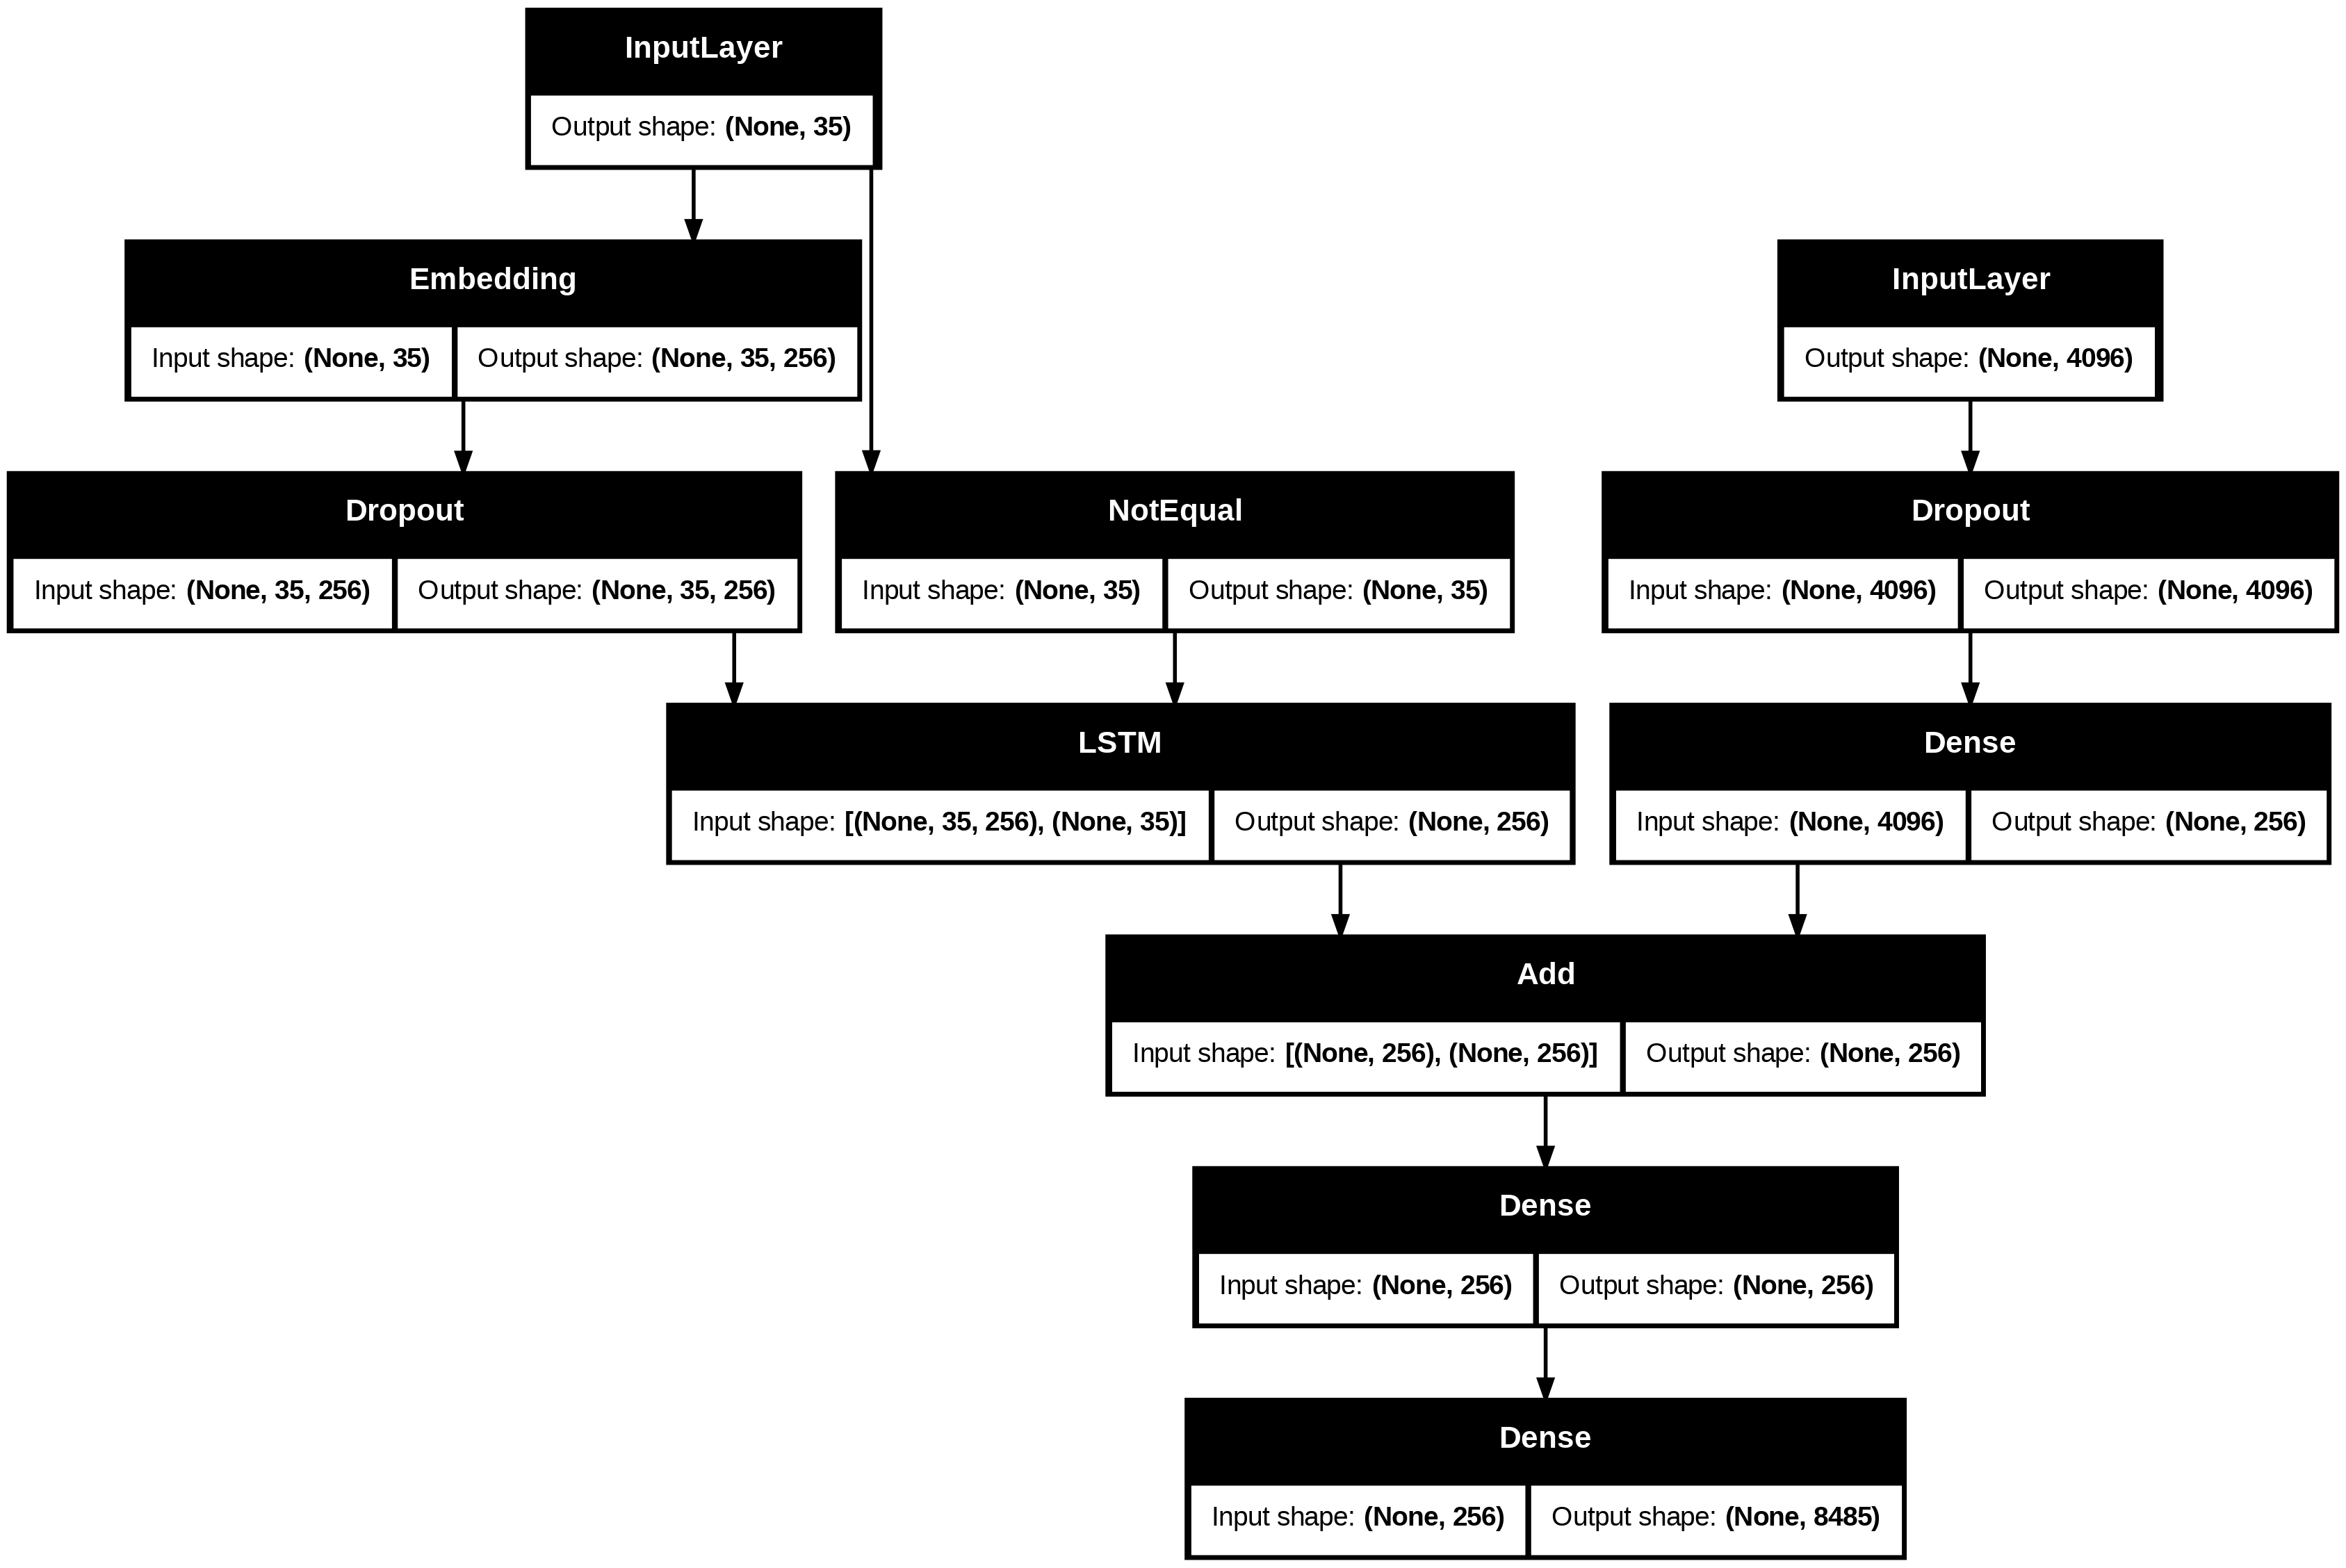

In [30]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
img_fe = Dropout(0.4)(inputs1)
img_features = Dense(256, activation='relu')(img_fe)

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
sequence_features = LSTM(256)(se2)

# decoder model
decoder1 = add([img_features, sequence_features])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1,inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [34]:
epochs = 20
batch_size = 32
steps_per_epoch = len(train_set) // batch_size
for i in range(epochs):
    # create data generator
    generator = data_generator(train_set ,mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps_per_epoch, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 242ms/step - loss: 5.8197
227/227 ━━━━━━━━━━━━━━━━━━━━ 55s 241ms/step - loss: 4.0840
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 237ms/step - loss: 3.5890
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 238ms/step - loss: 3.3013
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 232ms/step - loss: 3.0972
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 231ms/step - loss: 2.9424
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 234ms/step - loss: 2.8294
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 237ms/step - loss: 2.7363
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 238ms/step - loss: 2.6557
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 234ms/step - loss: 2.5828
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 240ms/step - loss: 2.5241
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 233ms/step - loss: 2.4725
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 234ms/step - loss: 2.4230
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 234ms/step - loss: 2.3761
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 232ms/step - loss: 2.3375
227/227 ━━━━━━━━━━━━━━━━━━━━ 53s 232ms/step - loss: 2.2926
227/227 ━━━━━━━━━━━━━━━━━━━━ 52s 230ms/step - loss: 2.25

In [59]:
model.save("best_model.h5")

### Generating captions for images:

In [60]:
def index_to_word(index,tokenizer):
    for word,i in tokenizer.word_index.items():
        if i == index:
            return word
    return None

In [82]:
def predict_caption(model, image_feature, tokenizer, max_length):
    in_text = "startseq"

    # convert image to correct type/shape
    image = np.array(image_feature, dtype='float32')
    if image.ndim == 1:
        image = image.reshape(1, -1)
    
    # convert to tensor with explicit shape
    image = tf.convert_to_tensor(image, dtype=tf.float32)

    for _ in range(max_length):
        # prepare sequence
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length, dtype='int32')
        seq = tf.convert_to_tensor(seq, dtype=tf.int32)

        # predict next word
        yhat = model([image, seq], training=False)   # use model() instead of model.predict()
        yhat = tf.argmax(yhat, axis=-1).numpy()[0]

        word = index_to_word(yhat, tokenizer)
        if word is None or word == "endseq":
            break
        in_text += " " + word

    return in_text


In [83]:
actual, predicted = list(), list()

for img in tqdm(test_set):
    if img not in features:      # safety check
        continue
    # get actual caption
    actual_captions = mapping[img]
    # predicted caption
    pred_caption = predict_caption(model, features[img], tokenizer, max_length)
    # split into words
    actual_caption_word = [caption.split() for caption in actual_captions]
    pred_caption_word = pred_caption.split()
    # append to list
    actual.append(actual_caption_word)
    predicted.append(pred_caption_word)

100%|██████████| 810/810 [23:51<00:00,  1.77s/it]


In [84]:
from nltk.translate.bleu_score import SmoothingFunction
smooth_fn = SmoothingFunction().method1

In [85]:
# calculate bleu score
bleu1 = corpus_bleu(actual, predicted, weights=(1, 0, 0, 0), smoothing_function=smooth_fn)
bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth_fn)
print("BLEU-1:", bleu1)
print("BLEU-2:", bleu2)

BLEU-1: 0.4826139088729017
BLEU-2: 0.2872972869033919


In [86]:
from PIL import Image
import matplotlib.pyplot as plt

In [93]:
def generate_caption(image_name):
    # load image
    image_id = image_name.split('.')[0]
    # load image from "Images" folder
    image_path = os.path.join(IMAGE_DIR, image_name)
    image = Image.open(image_path)
    captions = mapping[image_id]
    print("----------Actual----------")
    for caption in captions:
        print(caption)
    # predicting caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print("----------Predicted----------")
    print(y_pred)
    plt.imshow(image)

----------Actual----------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
----------Predicted----------
startseq woman in red dress is sitting on bench in front of wooden cabin


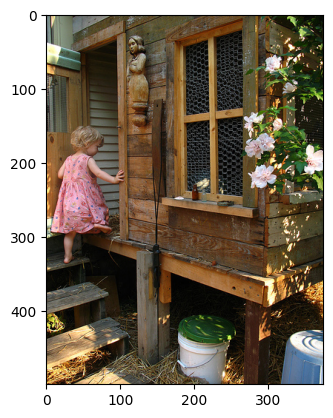

In [94]:
generate_caption("1000268201_693b08cb0e.jpg")

----------Actual----------
startseq man lays on bench while his dog sits by him endseq
startseq man lays on the bench to which white dog is also tied endseq
startseq man sleeping on bench outside with white and black dog sitting next to him endseq
startseq shirtless man lies on park bench with his dog endseq
startseq man laying on bench holding leash of dog sitting on ground endseq
----------Predicted----------
startseq man lays on bench with his arm on his back


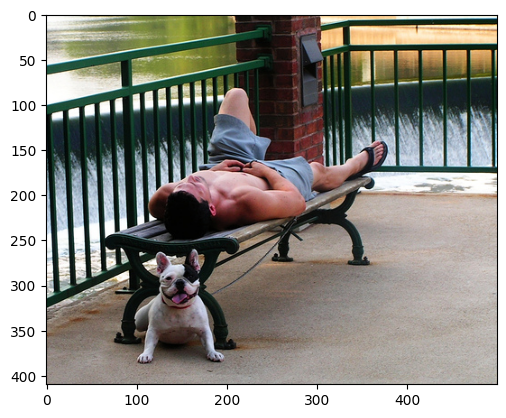

In [96]:
generate_caption("1003163366_44323f5815.jpg")

----------Actual----------
startseq two boys in field kicking soccer ball endseq
startseq two children are playing with soccer ball on grass endseq
startseq two children playing with ball on the grass endseq
startseq two children play soccer in the park endseq
startseq two little boys are playing outside with their soccer ball on the green grass endseq
----------Predicted----------
startseq boy in red tank top and white shirt is kicking the ball in the grass


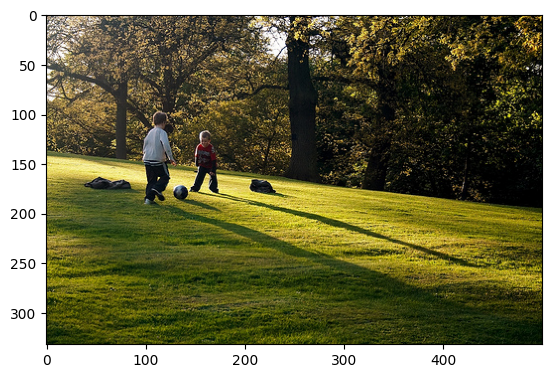

In [97]:
generate_caption("197504190_fd1fc3d4b7.jpg")